# ⚡️🐝 Quick-start with Xylo
This notebook gives you an ultra-quick overview of taking a network from high-level Python simulation through to deployment on the Xylo SNN HDK.

In [1]:
# - Numpy
import numpy as np

# - Matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams['figure.dpi'] = 300

# - Rockpool time-series handling
from rockpool import TSEvent, TSContinuous

# - Pretty printing
try:
    from rich import print
except:
    pass

# - Display images
from IPython.display import Image

# - Disable warnings
import warnings
warnings.filterwarnings('ignore')

## Xylo in numbers

## Step 1: Build a network in Rockpool
We will demonstrate with a straightforward network architecture, which shows off the support of Xylo. The network architecture is shown below. It consists of linear weights ("W"), spiking neuron layers ("LIF"), and a residual block containing a recurrent LIF layer (recurrent weights $W_{rec}$).

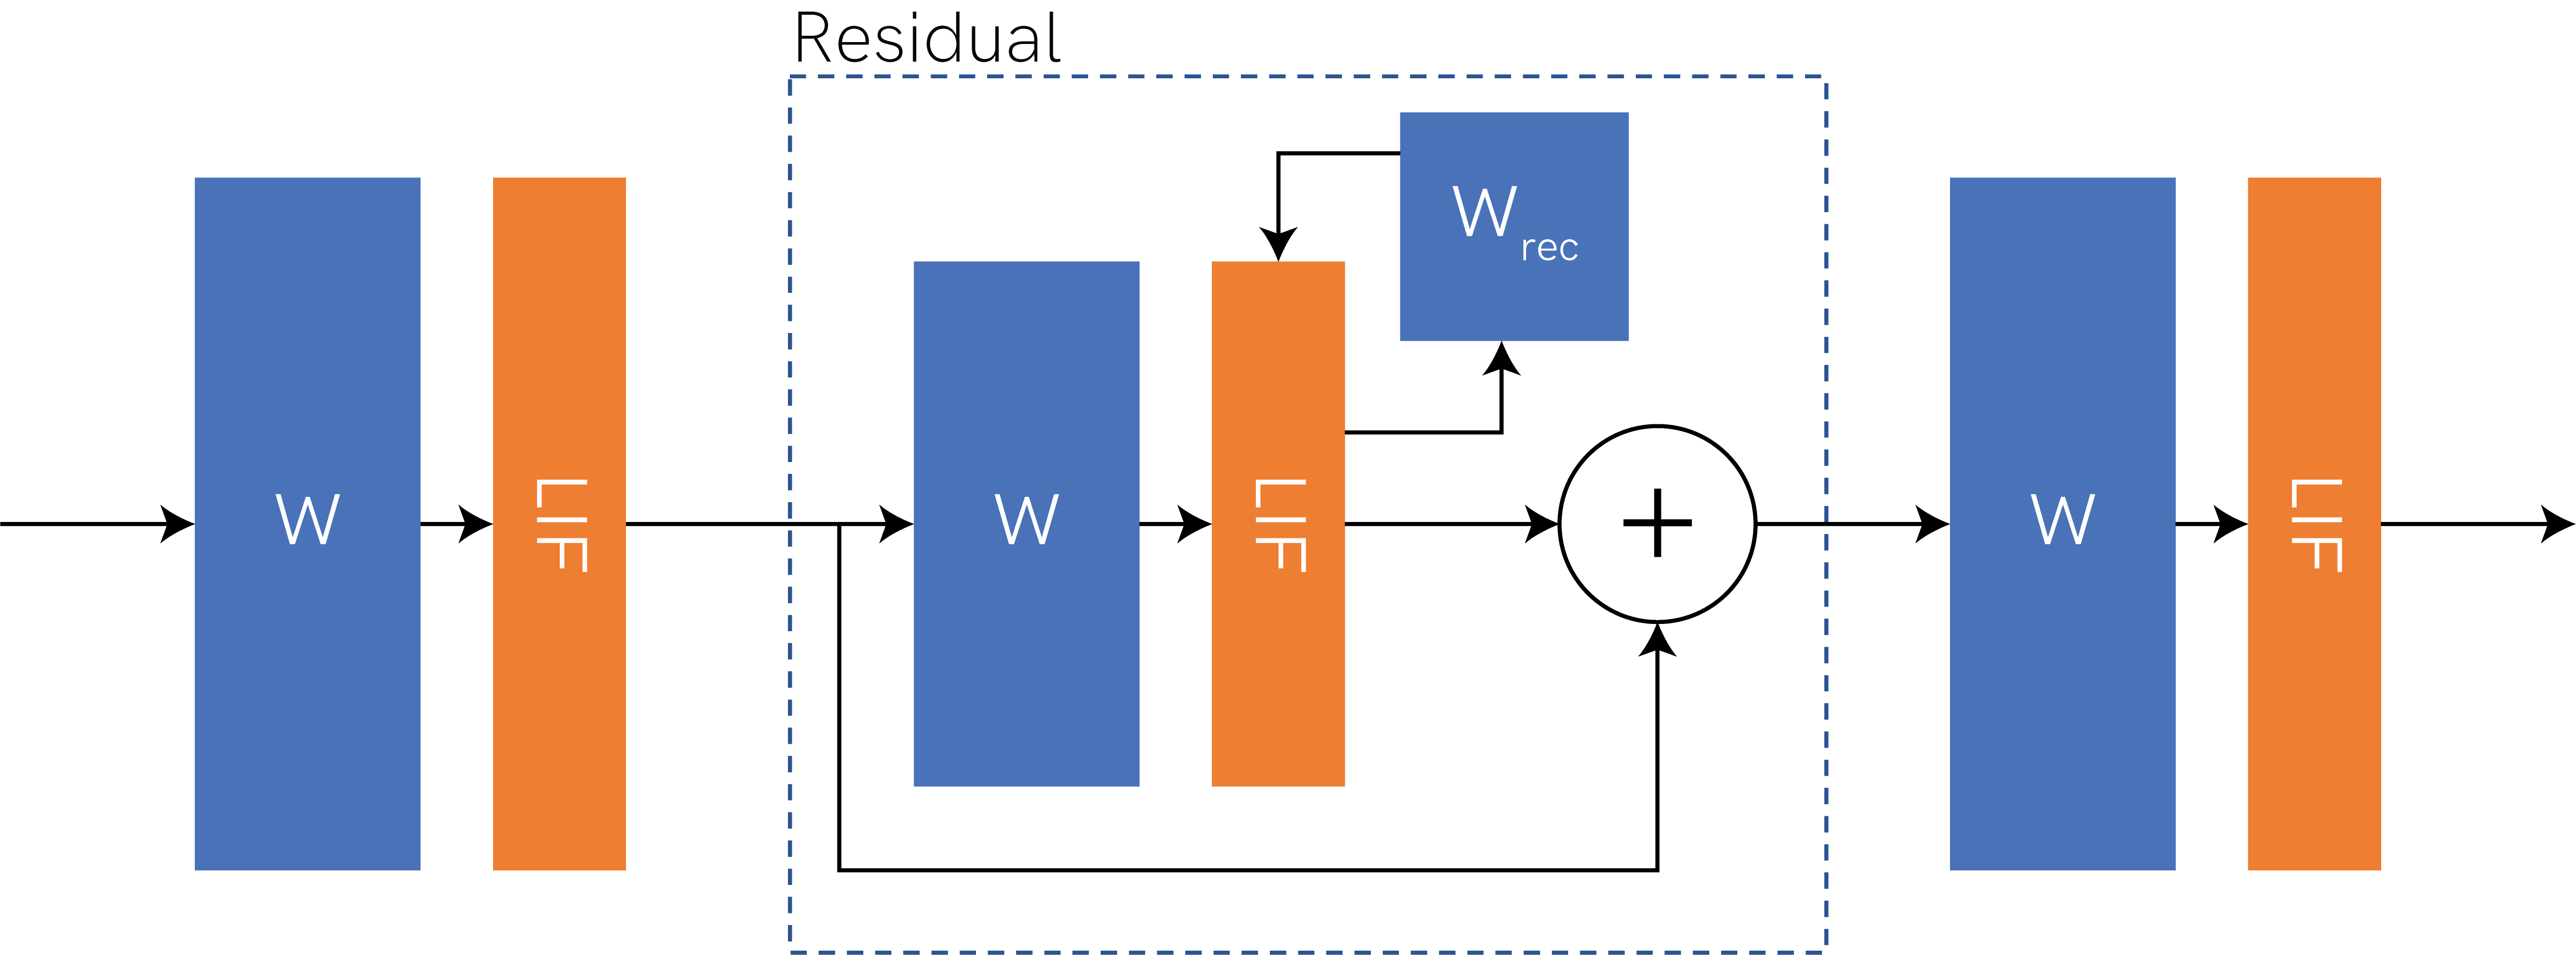

In [2]:
Image(filename='network-architecture.png')

In [3]:
# - Import the computational modules and combinators required for the networl
from rockpool.nn.modules import LIFTorch, LinearTorch
from rockpool.nn.combinators import Sequential, Residual

In [4]:
# - Define the size of the network layers
Nin = 2
Nhidden = 4
Nout = 2
dt = 1e-3

In [5]:
# - Define the network architecture using combinators and modules
net = Sequential(
    LinearTorch((Nin, Nhidden), has_bias = False),
    LIFTorch(Nhidden, dt = dt),
    
    Residual(
        LinearTorch((Nhidden, Nhidden), has_bias = False),
        LIFTorch(Nhidden, has_rec = True, threshold = 10., dt = dt),
    ),
    
    LinearTorch((Nhidden, Nout), has_bias = False),
    LIFTorch(Nout, dt = dt),
)
print(net)

TorchSequential  with shape (2, 2) {
    LinearTorch '0_LinearTorch' with shape (2, 4)
    LIFTorch '1_LIFTorch' with shape (4, 4)
    TorchResidual '2_TorchResidual' with shape (4, 4) {
        LinearTorch '0_LinearTorch' with shape (4, 4)
        LIFTorch '1_LIFTorch' with shape (4, 4)
    }
    LinearTorch '3_LinearTorch' with shape (4, 2)
    LIFTorch '4_LIFTorch' with shape (2, 2)
}

In [6]:
# - Scale down recurrent weights for stability
net[2][1].w_rec.data = net[2][1].w_rec / 10.

## Step 2: Extract the computational graph for the network

In [7]:
print(net.as_graph())

GraphHolder "TorchSequential__11261096816" with 2 input nodes -> 2 output nodes

## Step 3: Map the network to a hardware specification
We now need to check that the network can be supported by the Xylo hardware, and assign hardware resources to the various aspects of the network architecture.
For example, each neuron in the network must be assigned to a hardware neuron.
Each non-input weight element in the network must be assigned to a global hidden weight matrix for Xylo.
Output neurons in the final layer must be assigned to output channels.



The Xylo family includes sevral devices with differing HW blocks and support.
These are supported by independent subpackages under :py:mod:`rockpool.devices.xylo`, and named after the chip ID in your HDK.
Rockpool can detect this automatically for you, and import the correct package, by connecting to the HDK.

If you do not have a Xylo HDK, then you can use the :py:mod:`rockpool.devices.xylo.syns61201` package supporting Xylo-Audio 2.

In [8]:
# - Import the Xylo HDK detection function
from rockpool.devices.xylo import find_xylo_hdks

# - Detect a connected HDK and import the required support package
connected_hdks, support_modules, chip_versions = find_xylo_hdks()

found_xylo = len(connected_hdks) > 0

if found_xylo:
    hdk = connected_hdks[0]
    x = support_modules[0]
else:
    assert False, 'This tutorial requires a connected Xylo HDK to run.'

The connected Xylo HDK contains a Xylo SNN core (SYNS61300). Importing `rockpool.devices.xylo.syns61300`


In [9]:
# - Call the Xylo mapper on the extracted computational graph
spec = x.mapper(net.as_graph(), weight_dtype = 'float')

In [10]:
print(spec)

{
    'mapped_graph': GraphHolder "TorchSequential__11261096816" with 2 input nodes -> 2 output nodes,
    'weights_in': array([[-1.71412635,  1.15680206, -1.1021117 , -0.86906266,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 1.07595026, -1.57853854,  1.44402635,  0.35398209,  0.        ,
         0.        ,  0.        ,  0.        ]]),
    'weights_out': array([[ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [-0.69059539,  0.55810881],
       [ 1.11070263, -0.18627334],
       [-1.19703519,  0.57400119],
       [ 1.01294601,  0.53884828]]),
    'weights_rec': array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.89256346,
         0.71705389, -0.76920992, -0.14137483],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.53584075,
         0.6910429 ,  0.35250902, -0.14267385],
       [ 0.        ,  0.        ,  0.        ,  0.        , -0.32676566,
         1.21104491, -1.18330431, -0.52924669],
       [ 0.        ,  0.        ,  0.        ,  0.        , -0.04836023,
        -0.17723799,  0.9295913 , -0.95274746],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.08988372,
         0.09212409, -0.09910578, -0.12107694],
       [ 0.        ,  0.        ,  0.        ,  0.        , -0.00902866,
         0.0785205 ,  0.09335631,  0.11774036],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.07946102,
        -0.02263224,  0.05118501,  0.06033585],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.02908373,
         0.10010139,  0.06314083, -0.10866053]]),
    'dash_mem': array([4.32192802, 4.32192802, 4.32192802, 4.32192802, 4.32192802,
       4.32192802, 4.32192802, 4.32192802]),
    'dash_mem_out': array([4.32192802, 4.32192802]),
    'dash_syn': array([4.32192802, 4.32192802, 4.32192802, 4.32192802, 4.32192802,
       4.32192802, 4.32192802, 4.32192802]),
    'dash_syn_2': array([0., 0., 0., 0., 0., 0., 0., 0.]),
    'dash_syn_out': array([4.32192802, 4.32192802]),
    'threshold': array([ 1.,  1.,  1.,  1., 10., 10., 10., 10.]),
    'threshold_out': array([1., 1.]),
    'weight_shift_in': 0,
    'weight_shift_rec': 0,
    'weight_shift_out': 0,
    'aliases': [[4], [5], [6], [7], [], [], [], []],
    'dt': 0.001
}

## Step 4: Quantize the specfication for the Xylo integer logic

In [11]:
from rockpool.transform import quantize_methods as q

# - Quantize the specification
spec.update(q.global_quantize(**spec))
print(spec)

{
    'mapped_graph': GraphHolder "TorchSequential__11261096816" with 2 input nodes -> 2 output nodes,
    'weights_in': array([[-127,   86,  -82,  -64,    0,    0,    0,    0],
       [  80, -117,  107,   26,    0,    0,    0,    0]]),
    'weights_out': array([[   0,    0],
       [   0,    0],
       [   0,    0],
       [   0,    0],
       [ -73,   59],
       [ 118,  -20],
       [-127,   61],
       [ 107,   57]]),
    'weights_rec': array([[  0,   0,   0,   0,  66,  53, -57, -10],
       [  0,   0,   0,   0,  40,  51,  26, -11],
       [  0,   0,   0,   0, -24,  90, -88, -39],
       [  0,   0,   0,   0,  -4, -13,  69, -71],
       [  0,   0,   0,   0,   7,   7,  -7,  -9],
       [  0,   0,   0,   0,  -1,   6,   7,   9],
       [  0,   0,   0,   0,   6,  -2,   4,   4],
       [  0,   0,   0,   0,   2,   7,   5,  -8]]),
    'dash_mem': array([4, 4, 4, 4, 4, 4, 4, 4]),
    'dash_mem_out': array([4, 4]),
    'dash_syn': array([4, 4, 4, 4, 4, 4, 4, 4]),
    'dash_syn_2': array([0, 0, 0, 0, 0, 0, 0, 0]),
    'dash_syn_out': array([4, 4]),
    'threshold': array([ 74,  74,  74,  74, 741, 741, 741, 741]),
    'threshold_out': array([106, 106]),
    'weight_shift_in': 0,
    'weight_shift_rec': 0,
    'weight_shift_out': 0,
    'aliases': [[4], [5], [6], [7], [], [], [], []],
    'dt': 0.001
}

## Step 5: Convert the specification to a hardware configuration
We now convert the network specification to a hardware configuration object for the Xylo HDK.

In [12]:
# - Use rockpool.devices.xylo.config_from_specification
config, is_valid, msg = x.config_from_specification(**spec)
if not is_valid:
    print(msg)

## Step 6: Deploy the configuration to the Xylo HDK

In [13]:
# - Use rockpool.devices.xylo.XyloSamna to deploy to the HDK
if found_xylo:
    modSamna = x.XyloSamna(hdk, config, dt = dt)
    print(modSamna)

XyloSamna  with shape (2, 8, 2)

## Step 7: Evolve the network on the Xylo HDK
Now we will generate a random Poisson input, and evolve the network on the Xylo HDK using this input.
Using Rockpool we can record all internal states on the Xylo HDK during evolution.
*Note that recording internal state slows evolution below real-time.*

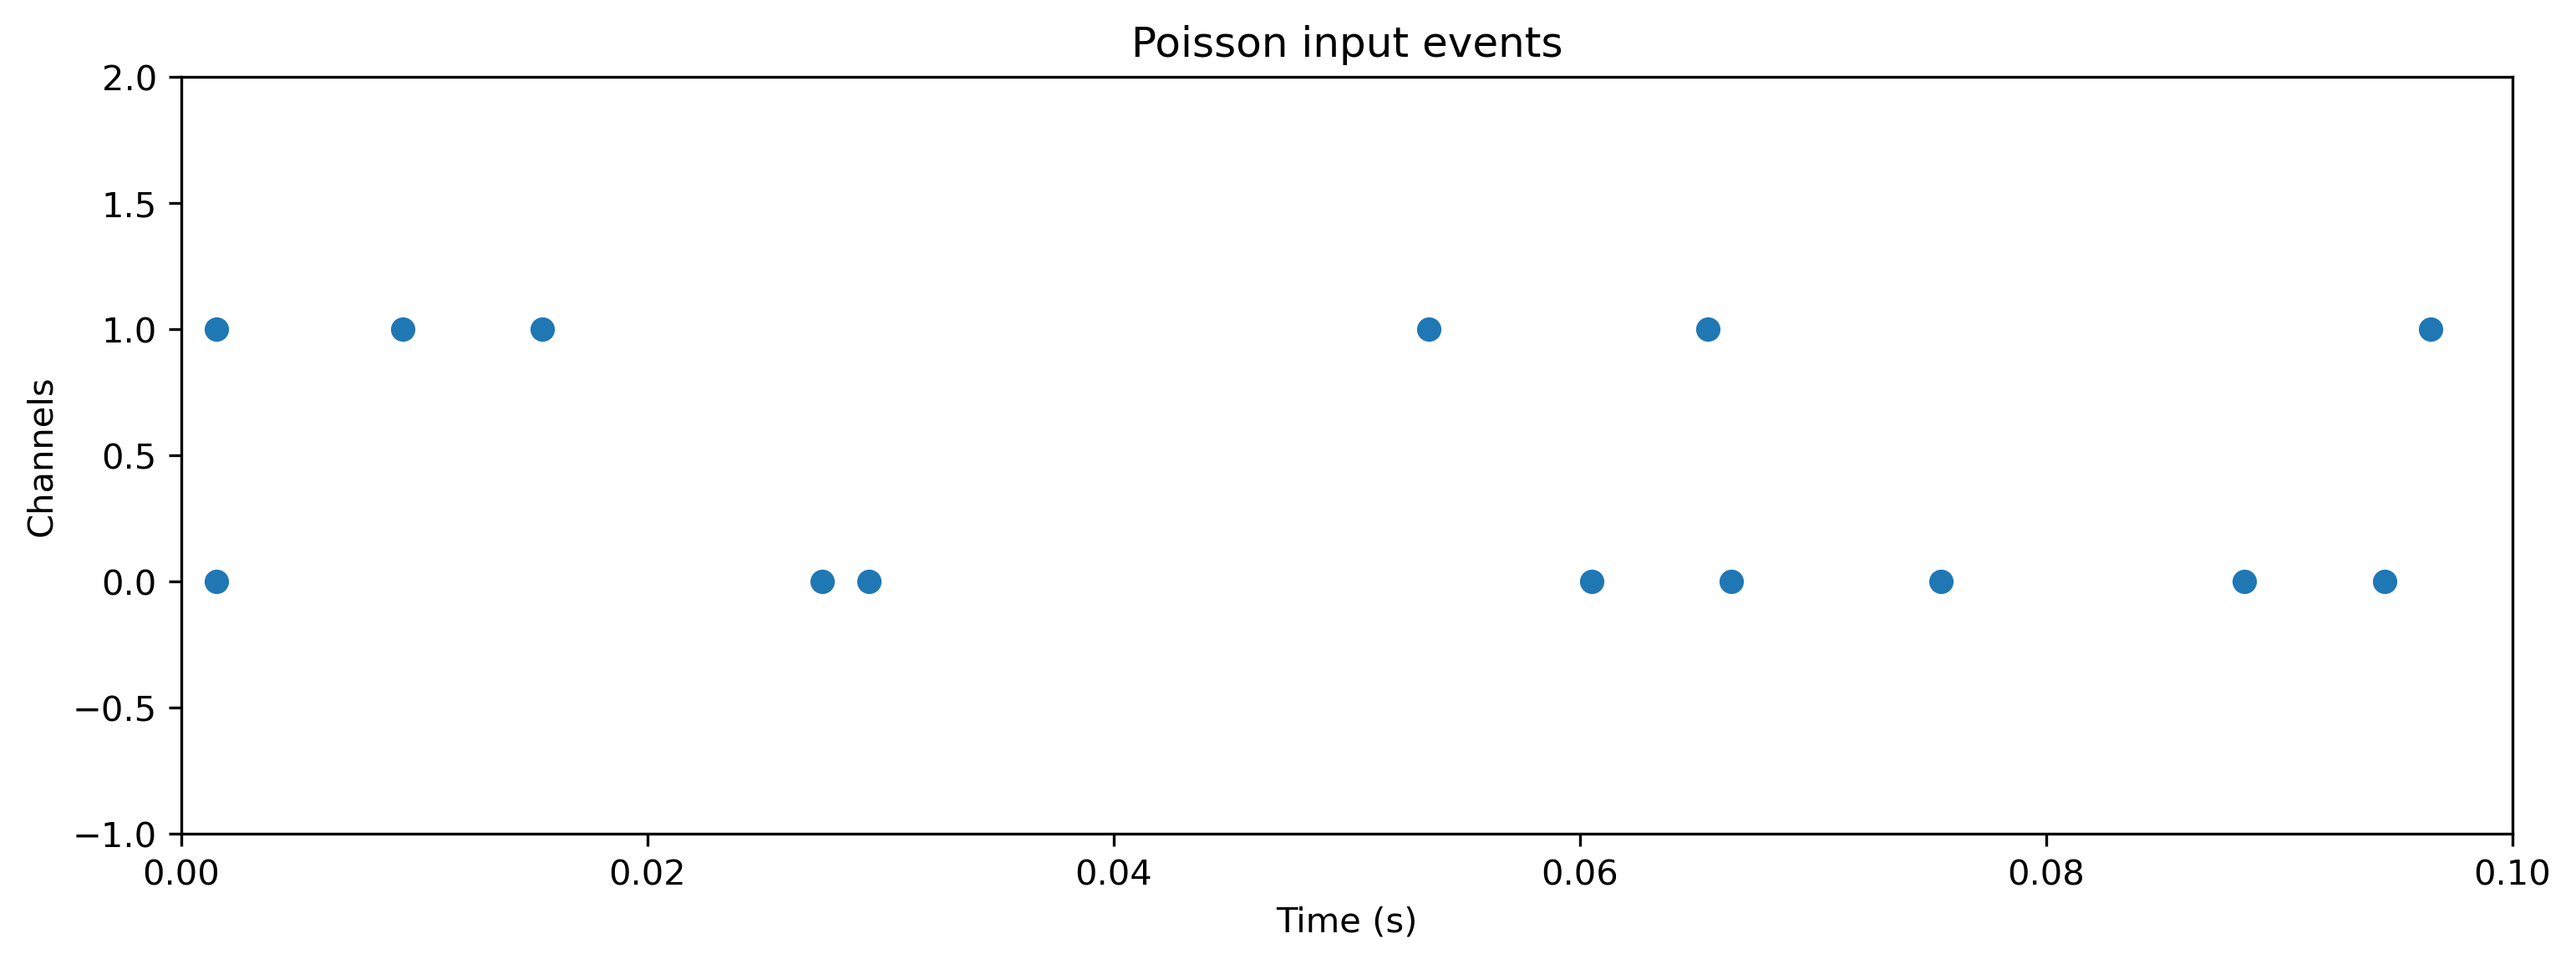

In [14]:
# - Generate some Poisson input
T = 100
f = 0.1
input_spikes = np.random.rand(T, Nin) < f
TSEvent.from_raster(input_spikes, dt, name = 'Poisson input events').plot();

In [15]:
# - Evolve the network on the Xylo HDK
if found_xylo:
    out, _, r_d = modSamna(input_spikes, record = True)
    
    # - Show the internal state variables recorded 
    print(r_d.keys())

dict_keys(['Vmem', 'Isyn', 'Isyn2', 'Spikes', 'Vmem_out', 'Isyn_out', 'times'])

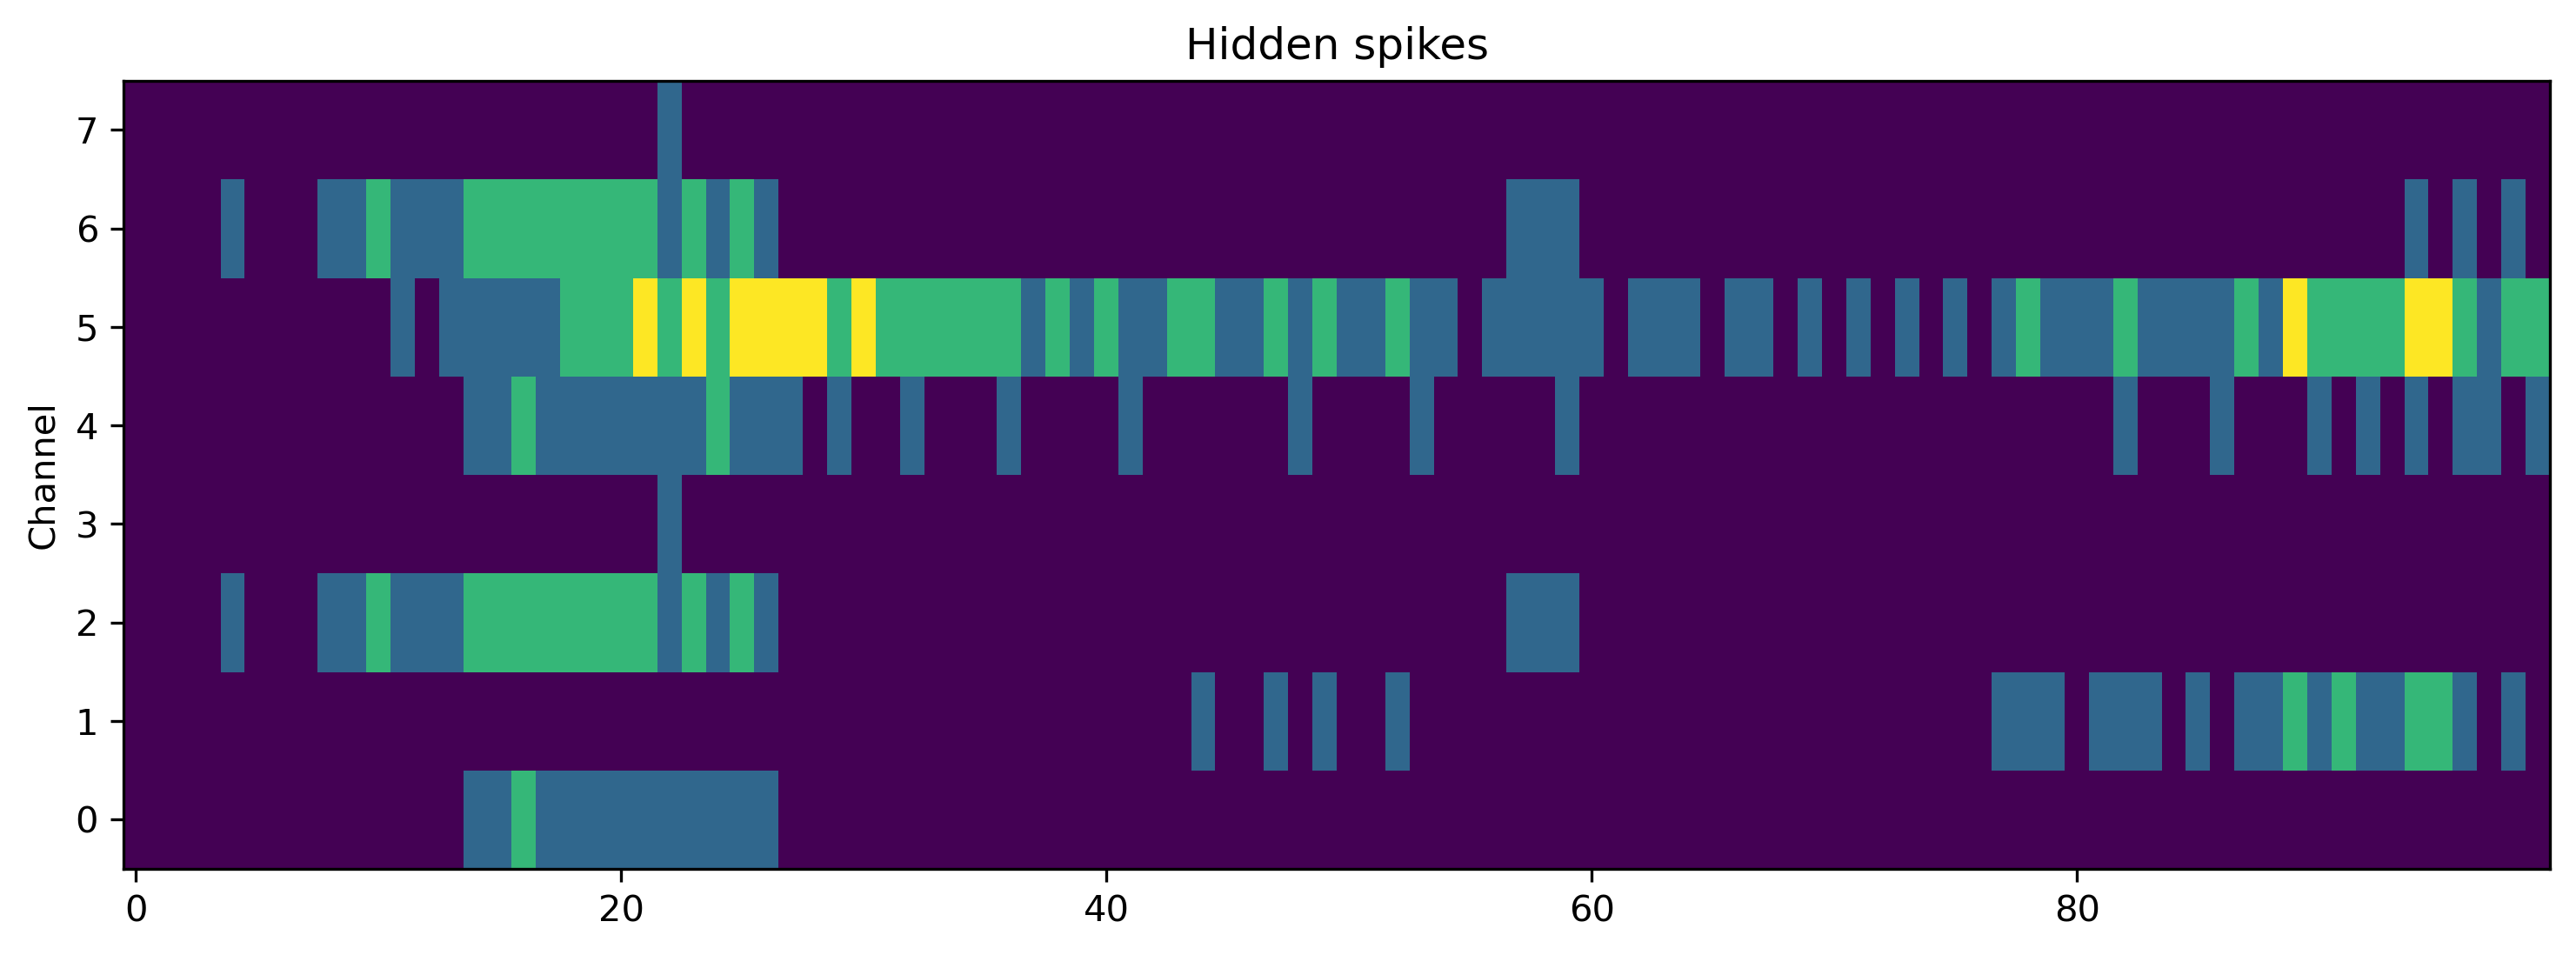

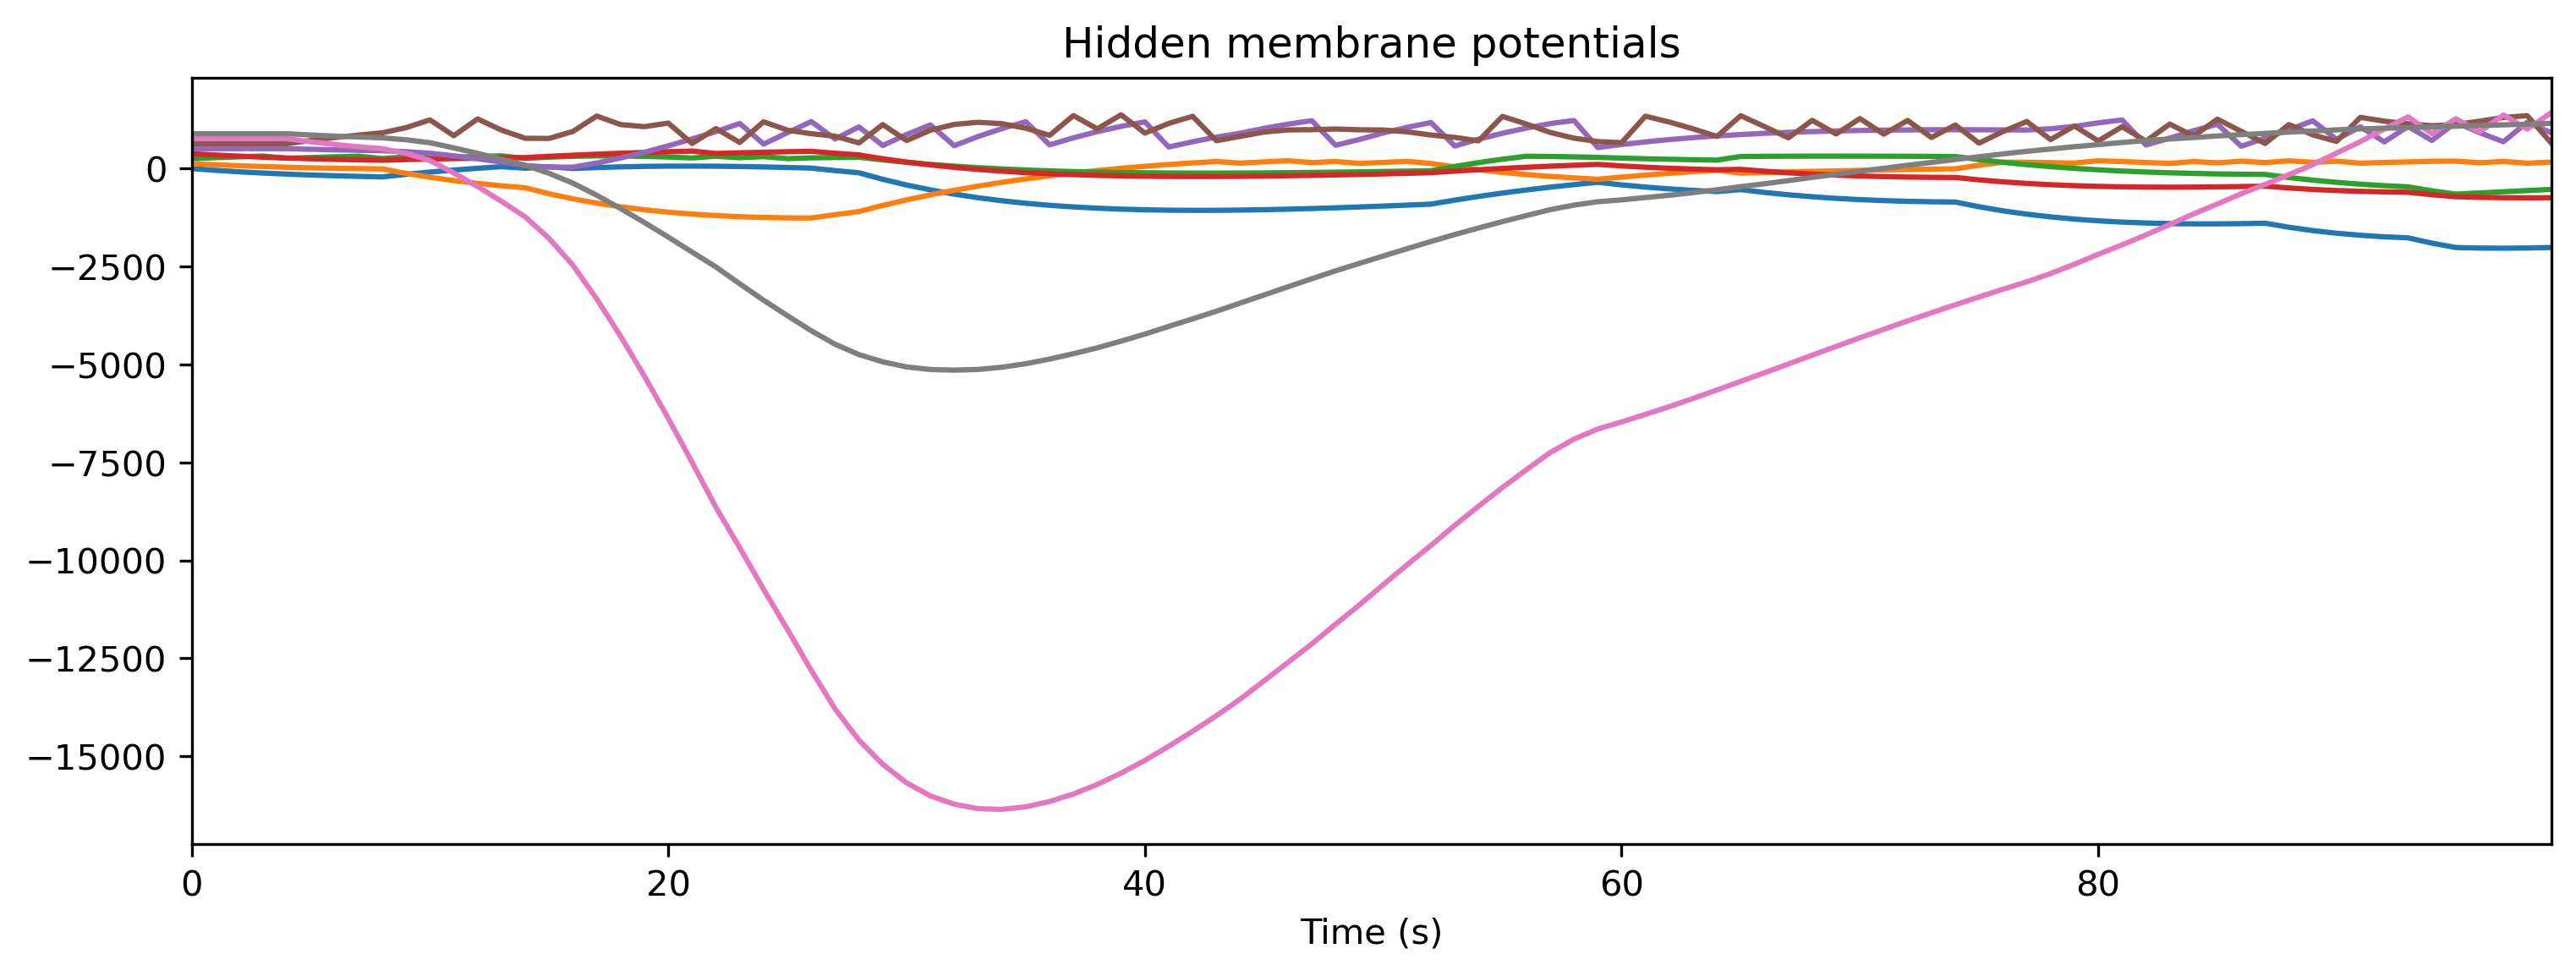

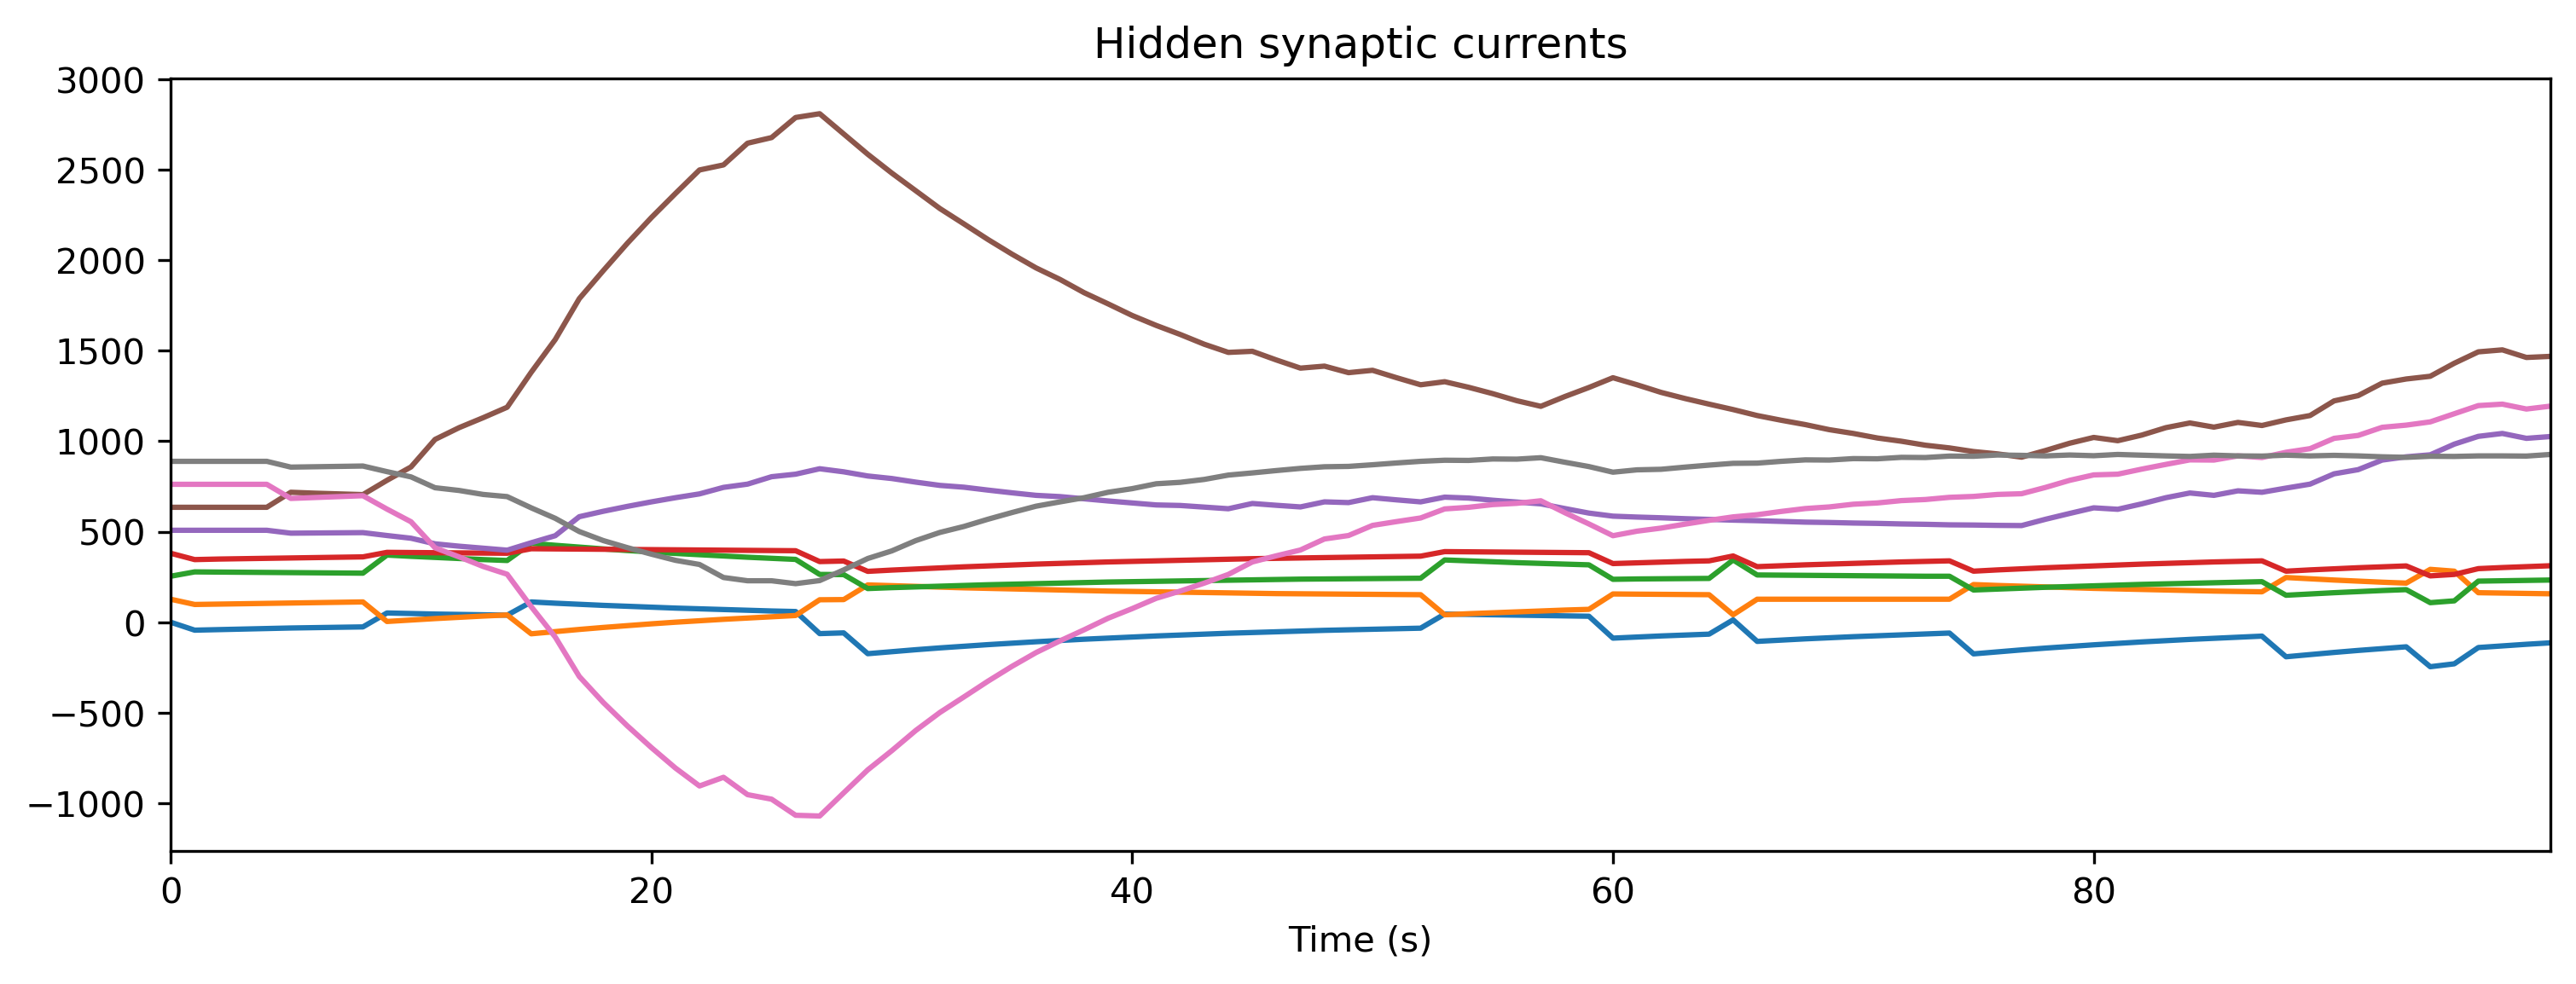

In [16]:
# - Plot some internal state variables
if found_xylo:
    plt.figure()
    plt.imshow(r_d['Spikes'].T, aspect = 'auto', origin = 'lower')
    plt.title('Hidden spikes')
    plt.ylabel('Channel')
    
    plt.figure()
    TSContinuous(r_d['times'], r_d['Vmem'], name = 'Hidden membrane potentials').plot(stagger = 127)

    plt.figure()
    TSContinuous(r_d['times'], r_d['Isyn'], name = 'Hidden synaptic currents').plot(stagger = 127)

## Step 8: Simulate the HDK using a bit-precise simulator

In [17]:
modSim = x.XyloSim.from_config(config)
print(modSim)

XyloSim  with shape (16, 1000, 8)

In [18]:
# - Evolve the input over the network, in simulation
out, _, r_d = modSim(input_spikes, record = True)

# - Show the internal state variables recorded 
print(r_d.keys())

dict_keys(['Vmem', 'Isyn', 'Isyn2', 'Spikes', 'Vmem_out', 'Isyn_out'])

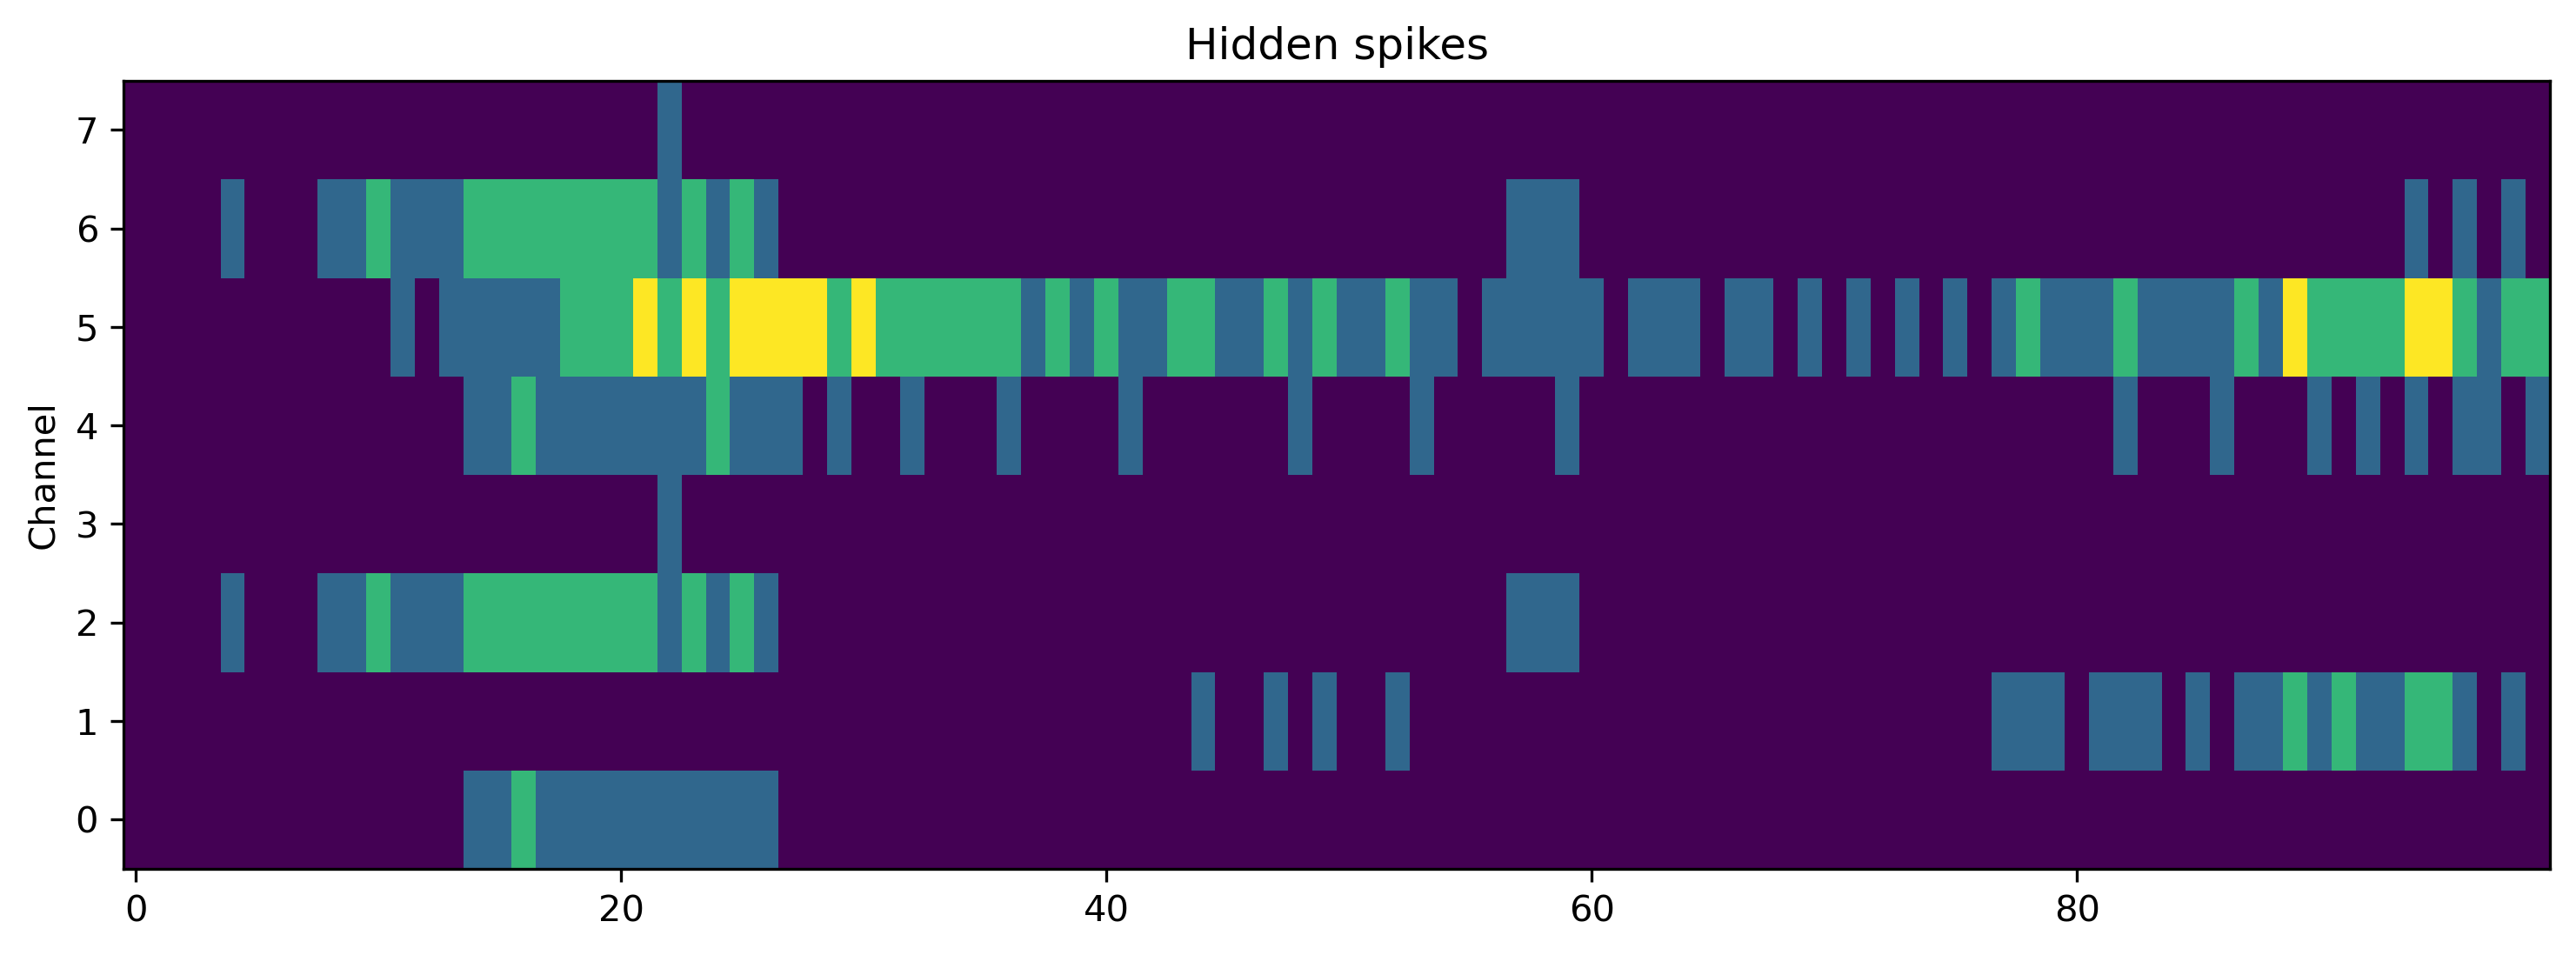

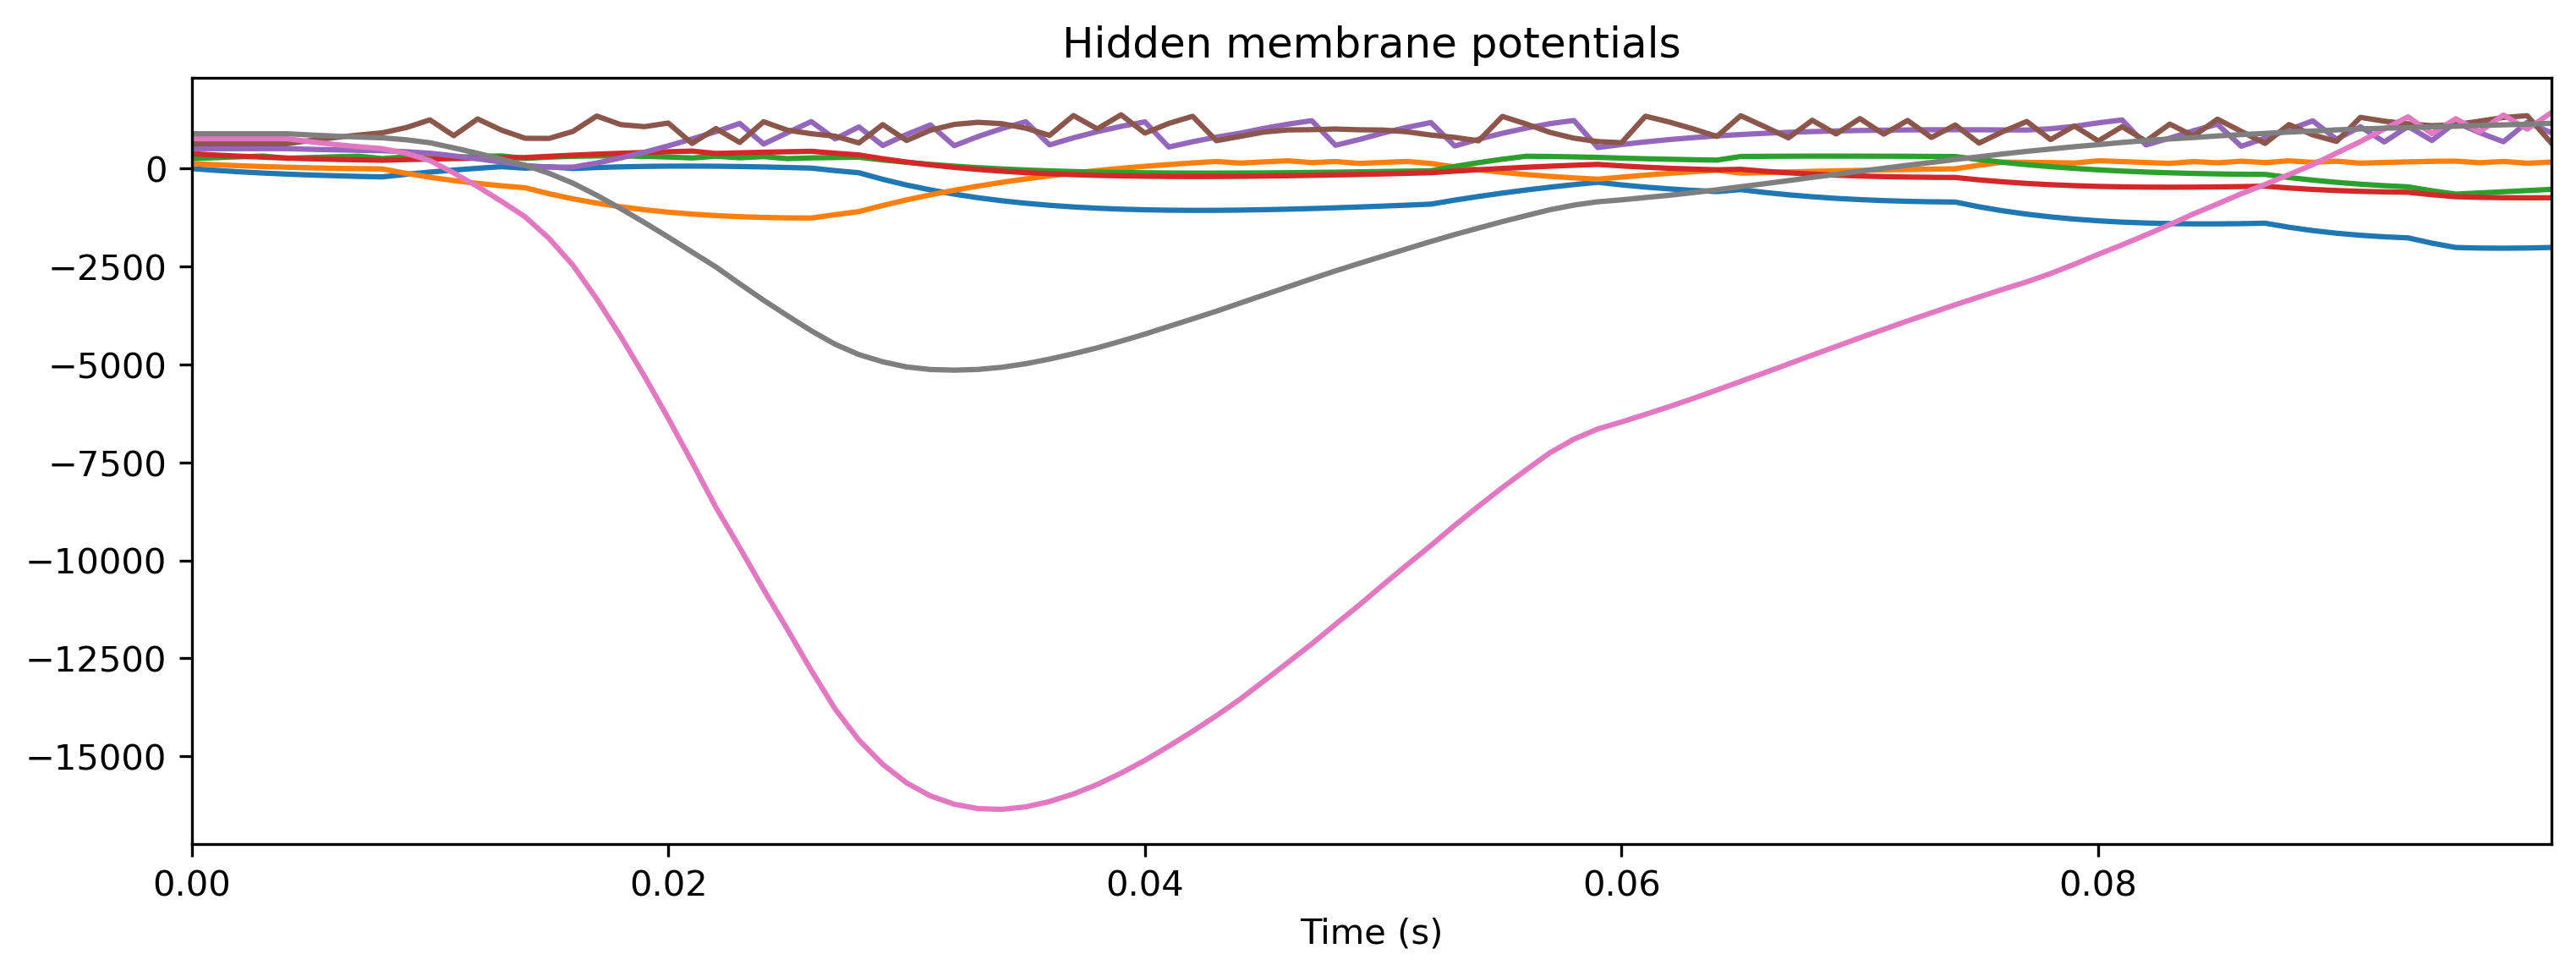

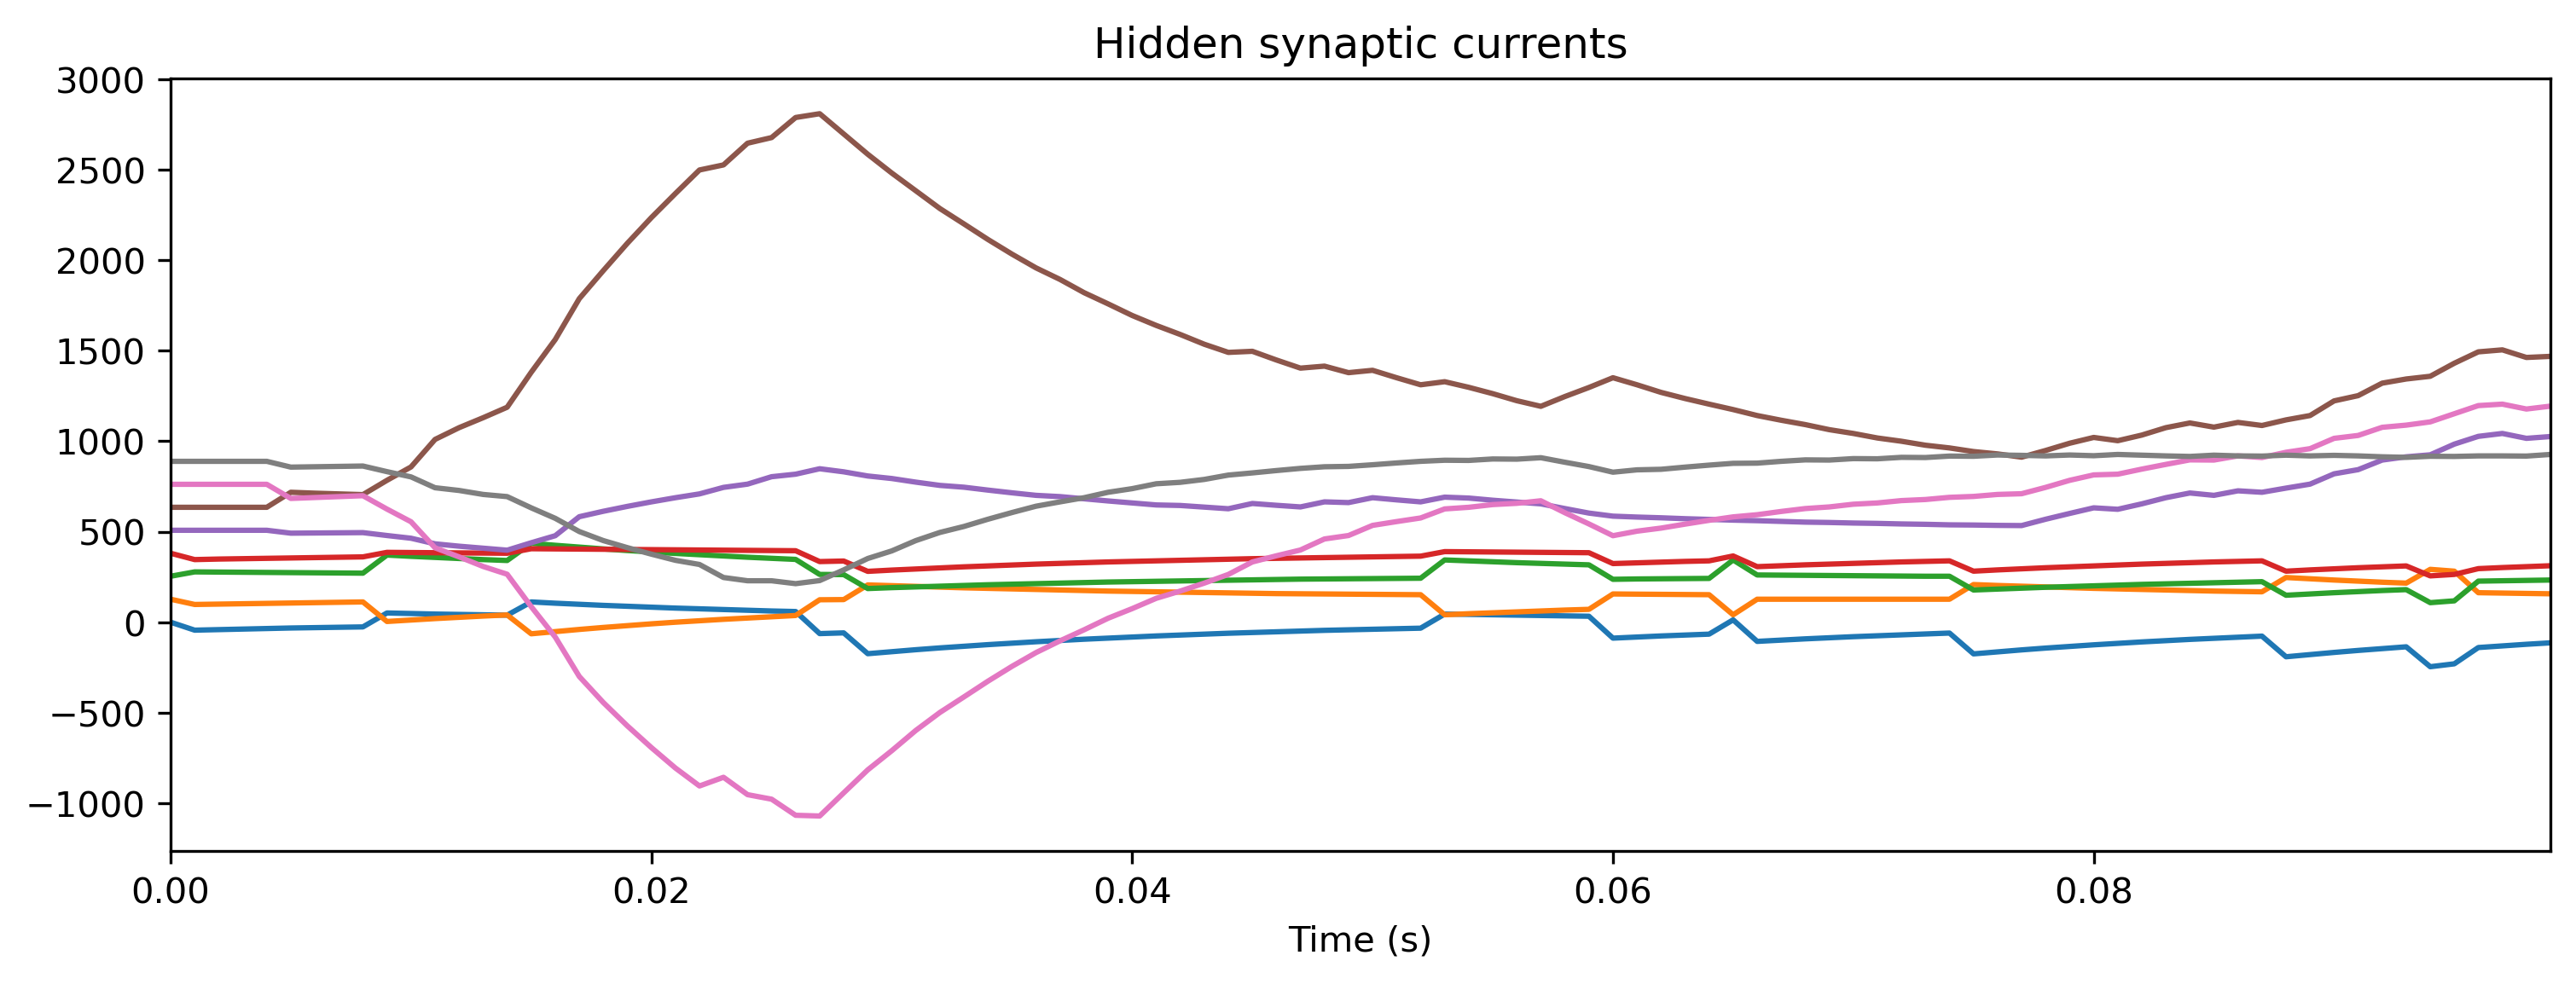

In [19]:
# - Plot some internal state variables
plt.figure()
plt.imshow(r_d['Spikes'].T, aspect = 'auto', origin = 'lower')
plt.title('Hidden spikes')
plt.ylabel('Channel')

plt.figure()
TSContinuous.from_clocked(r_d['Vmem'], dt, name = 'Hidden membrane potentials').plot(stagger = 127)

plt.figure()
TSContinuous.from_clocked(r_d['Isyn'], dt, name = 'Hidden synaptic currents').plot(stagger = 127);

## Summary
The flow-chart below summarises the steps in taking a Rockpool network from a high-level definition to deployment on the Xylo HDK.

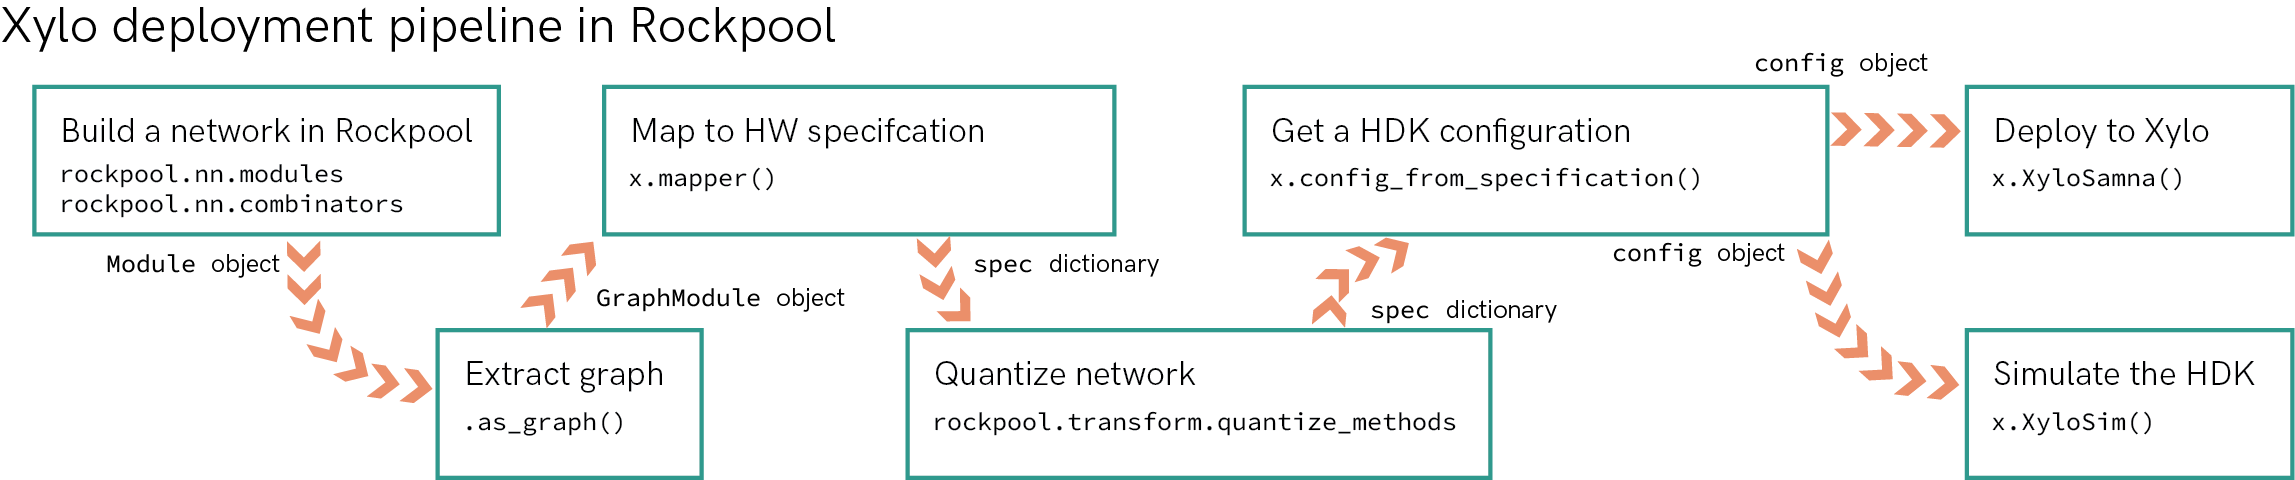

In [20]:
Image(filename='xylo-pipeline.png')